# Demonstration of implemented algorithms #

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sparse
import ALS
import SoftInput
import RiemannianOptimization as Riemann
import time
from scipy.sparse import linalg

## Experiment 1. Skoltech building ##

Here we download a photo of one of the buildings in Mendeleev Quarter. After that we set only about 5% of pixels to be known and then we try to repair the photo using some of implemented algorithms.

In [2]:
img = np.array(Image.open('sk.png'), dtype=np.uint8)

Randomly choosing known pixels and creating damaged image:

In [3]:
# random init
np.random.seed(25)
num = img.size // 30

np.random.seed(25)
row_ind = np.random.randint(0, img[:, : ,0].shape[0], size=num)
col_ind = np.random.randint(0, img[:, :, 0].shape[1], size=num)

# we assume that pixels at main diagonal are known to be sure that at least one
# pixel at each row and at each column is known
row_ind = np.append(row_ind, np.arange(img[:, :, 0].shape[0]))
col_ind = np.append(col_ind, np.arange(img[:, :, 0].shape[0]))

X_r = sparse.csr_matrix((img[(row_ind, col_ind, 0)], (row_ind, col_ind)), shape=img[:, :, 0].shape, dtype=np.float)
X_g = sparse.csr_matrix((img[(row_ind, col_ind, 1)], (row_ind, col_ind)), shape=img[:, :, 0].shape, dtype=np.float)
X_b = sparse.csr_matrix((img[(row_ind, col_ind, 2)], (row_ind, col_ind)), shape=img[:, :, 0].shape, dtype=np.float)

In [4]:
damaged_img = np.dstack((X_r.toarray(), X_g.toarray(), X_b.toarray()))
damaged_img = np.array(damaged_img, dtype=np.uint8)

In [5]:
riemann_r = Riemann.RiemannianOptimization(X_r, tau=1e-16, rank=96, maxiter=5, accuracy=1e-16)
start_time = time.time()
riemann_r.LRGeomCG()
print("--- %s seconds ---" % (time.time() - start_time))

--- 3.3378212451934814 seconds ---


Completion via Riemannian Optimization:

In [6]:
Answ = riemann_r.create_Xw(riemann_r.approx)
linalg.norm(Answ-X_r)

236.25426692032241

In [7]:
np.random.seed(25)
riemann_r = Riemann.RiemannianOptimization(X_r, tau=1e-16, rank=96, maxiter=700, accuracy=1e-16)
riemann_g = Riemann.RiemannianOptimization(X_g, tau=1e-16, rank=96, maxiter=700, accuracy=1e-16)
riemann_b = Riemann.RiemannianOptimization(X_b, tau=1e-16, rank=96, maxiter=700, accuracy=1e-16)

In [8]:
riemann_r.LRGeomCG()
riemann_g.LRGeomCG()
riemann_b.LRGeomCG()

In [9]:
U = riemann_r.approx[0]
S = riemann_r.approx[1]
V = riemann_r.approx[2]
Ans_r = np.array(U.dot(S.dot(V.T)), dtype=np.uint8)

U = riemann_g.approx[0]
S = riemann_g.approx[1]
V = riemann_g.approx[2]
Ans_g = np.array(U.dot(S.dot(V.T)), dtype=np.uint8)

U = riemann_b.approx[0]
S = riemann_b.approx[1]
V = riemann_b.approx[2]
Ans_b = np.array(U.dot(S.dot(V.T)), dtype=np.uint8)

Completion via Soft-Input:

In [11]:
np.random.seed(25)
si_r = SoftInput.SoftInput(X_r)
si_g = SoftInput.SoftInput(X_g)
si_b = SoftInput.SoftInput(X_b)

In [12]:
lambdas = np.linspace(0, 100, 10)

lambdas, appr_r_U, appr_r_Vt  = si_r.fit(lambdas=lambdas, maxiter=2000, start_rank=100, tol=1e-6)
lambdas, appr_g_U, appr_g_Vt = si_g.fit(lambdas=lambdas, maxiter=2000, start_rank=100, tol=1e-6)
lambdas, appr_b_U, appr_b_Vt = si_b.fit(lambdas=lambdas, maxiter=2000, start_rank=100, tol=1e-6)

In [13]:
Ans_r_si = np.array(appr_r_U[-1].dot(appr_r_Vt[-1]), dtype=np.uint8)
Ans_g_si = np.array(appr_g_U[-1].dot(appr_g_Vt[-1]), dtype=np.uint8)
Ans_b_si = np.array(appr_b_U[-1].dot(appr_b_Vt[-1]), dtype=np.uint8)

Demonstration of the results:

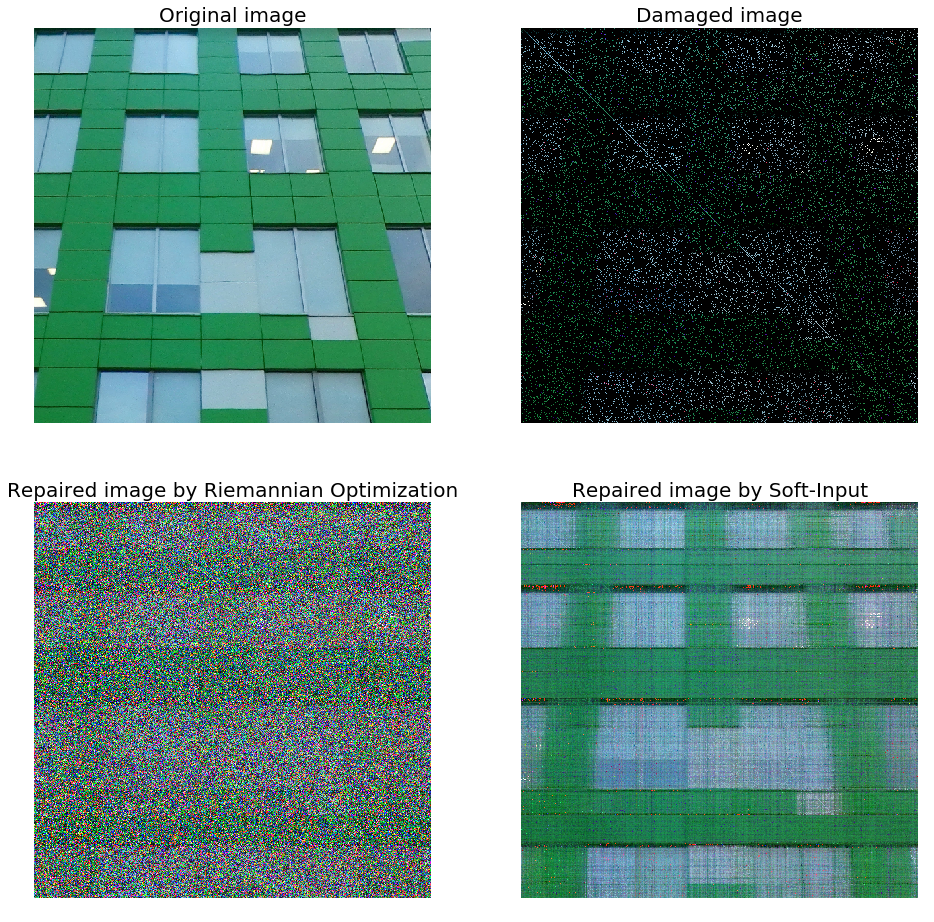

In [14]:
plt.figure(figsize=(16, 16))

plt.subplot(221)
plt.imshow(img)
plt.axis('off')
plt.title('Original image', fontsize=20)

plt.subplot(222)
plt.imshow(damaged_img)
plt.axis('off')
plt.title('Damaged image', fontsize=20)

plt.subplot(223)
plt.imshow(np.dstack((Ans_r, Ans_g, Ans_b)))
plt.axis('off')
plt.title('Repaired image by Riemannian Optimization', fontsize=20)

plt.subplot(224)
plt.imshow(np.dstack((Ans_r_si, Ans_g_si, Ans_b_si)))
plt.axis('off')
plt.title('Repaired image by Soft-Input', fontsize=20)

plt.show()

** Conclusion ** We managed to find pretty completion using Soft-Input. Completion found with Riemannian Optimization doesn't seem to be very good, but note that the formulation of completion problem solving by Riemannian Optimization is not convex and can have more than one local optimas. So, we probably converged to a wrong local optima:

In [15]:
print('Red component Riemannian Error %e' %(riemann_r.residuals[-1]))
print('Green component Riemannian Error %e' %(riemann_g.residuals[-1]))
print('Blue component Riemannian Error %e' %(riemann_b.residuals[-1]))

Red component Riemannian Error 1.993189e-08
Green component Riemannian Error 1.976598e-08
Blue component Riemannian Error 1.772803e-08


# Time convergence

In this section we will analyze the speed of convergence of ALS and Riemannian Optimization on the example of $X_r$ from the previous section. To do this, we will asuume that each iteration in ALS require the equal time. We will make the same assumption concerning RiemannianOptimization algorithm.

In [16]:
def create_grid(bias, step):
    
    grid = []
    S = 0
    for it in range(0, bias.size):
        grid.append(S)
        S += step
    return(grid)

# ALS

In [17]:
als = ALS.ALS(k=100, lambda_= 0.1, max_iter=20)

In [18]:
start_time = time.time()
als.fit(X_r)
als_time = (time.time() - start_time)
print("--- %s seconds ---" % als_time)

--- 110.5788803100586 seconds ---


In [19]:
als_time_iter = (time.time() - start_time)/als.get_bias().size
als_time_iter

5.529310405254364

# Riemann

In [20]:
riemann = Riemann.RiemannianOptimization(X_r, tau=1e-16, rank=96, maxiter=100, accuracy=1e-16)

In [21]:
np.random.seed(25)
start_time = time.time()
riemann.LRGeomCG()
riman_time = time.time() - start_time
print("--- %s seconds ---" % riman_time)

--- 23.5250723361969 seconds ---


In [22]:
riman_time_iter = (time.time() - start_time)/np.array(riemann.residuals).size
riman_time_iter

0.5602849211011615

# Soft Input

In [23]:
soft_input = SoftInput.SoftInput(X_r)

In [24]:
lambdas = np.linspace(0, 100, 10)
start_time = time.time()
lambdas, si_U, si_vt = soft_input.fit(lambdas=lambdas, maxiter=2000, start_rank=100, tol=1e-6)
soft_time = time.time() - start_time
print("--- %s seconds ---" % soft_time)

--- 507.03595304489136 seconds ---


In [25]:
soft_input_time_iter = soft_time/soft_input.bias.size
soft_input_time_iter

0.45802705785446374

# Analysis

In [26]:
riman_grid = create_grid(np.array(riemann.residuals), riman_time_iter)
als_grid = create_grid(als.get_bias(), als_time_iter)
soft_grid = create_grid(soft_input.bias, soft_input_time_iter)

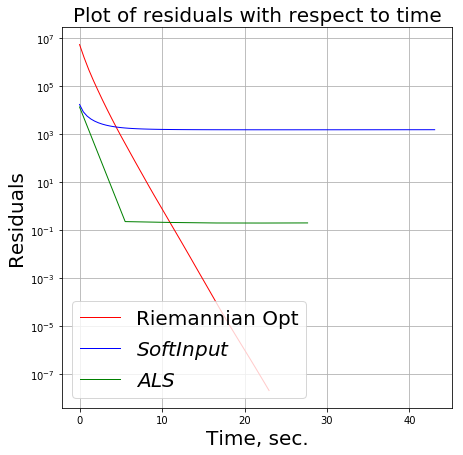

In [27]:
% matplotlib inline
fig = plt.figure(figsize=(7,7))
plt.plot(riman_grid[:], riemann.residuals[:], linewidth=1,color='r', label=r'Riemannian Opt')
plt.plot(soft_grid[:95], soft_input.bias[:95], linewidth=1,color='b', label=r'$Soft Input$')
plt.plot(als_grid[:6], als.get_bias()[:6], linewidth=1,color='g', label=r'$ALS$')

plt.title('Plot of residuals with respect to time', fontsize = 20)
plt.grid()
plt.legend(fontsize=20, loc=3)
plt.yscale('log')

plt.ylabel('Residuals', fontsize=20)
plt.xlabel('Time, sec.', fontsize = 20)

# Experiment 2.Working with images using ALS##

In this section 

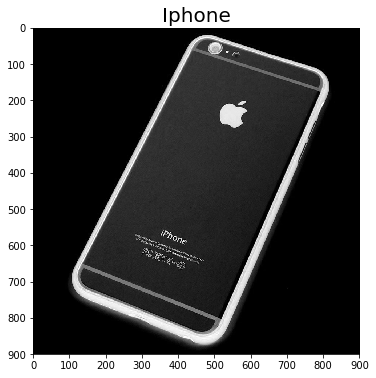

In [28]:
img = -1 * np.array(Image.open('iphone.jpg'), dtype=np.float64)[:,:, 0]
plt.figure(figsize=(14,6))
plt.subplot(111)
plt.title('Iphone', fontsize=20)
plt.imshow(img, cmap='gray')
plt.show()

In [29]:
print('Rank of this image: ', np.linalg.matrix_rank(img))

Rank of this image:  746


In [30]:
#this function works only for square images.
def create_low_rank_approximation(img, max_diff):
    u, s, v = np.linalg.svd(img)
    appr_rank = img.shape[0]
    
    for i in range(1, img.shape[0]):
        img_appr = np.dot(u[:, :i] * s[:i], v[:i, :])
        if np.linalg.norm(img_appr - img) / np.linalg.norm(img) < max_diff:
            appr_rank = i
            break
    return np.dot(u[:, :appr_rank] * s[:appr_rank], v[:appr_rank, :])

In [31]:
# create low rank approximation of initial image
new_img = create_low_rank_approximation(img, 0.05)
rank_for_repair = np.linalg.matrix_rank(new_img)
print('Rank of approximation: ', rank_for_repair)

Rank of approximation:  44


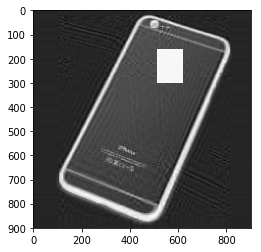

In [32]:
#now we delete 'delete' information about apple in the pic
new_img[160:300, 510:620] = 0
plt.imshow(new_img, cmap=plt.cm.gray)
plt.show()

In [33]:
X = sparse.coo_matrix(new_img)
a = ALS.ALS(k=rank_for_repair, lambda_=1, max_iter=15)
a.fit(X)

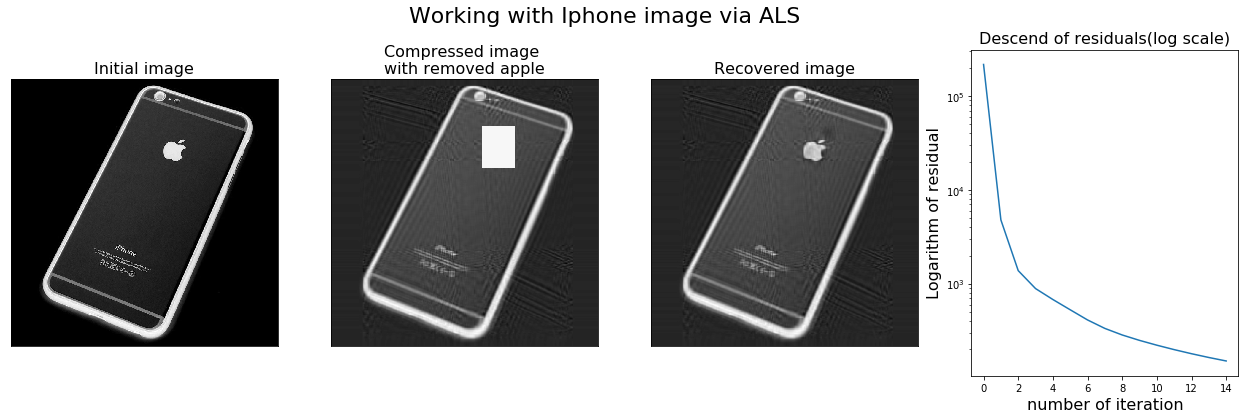

In [34]:
fig, fig1 = plt.subplots(1,4, figsize=(22,6))
fig.suptitle('Working with Iphone image via ALS', fontsize=22)

fig1[0].set_title('Initial image', fontsize=16)
fig1[0].imshow(img, cmap='gray')
fig1[0].axes.get_yaxis().set_visible(False)
fig1[0].axes.get_xaxis().set_visible(False)

fig1[1].set_title('Compressed image \nwith removed apple', fontsize=16)
fig1[1].imshow(new_img, cmap='gray')
fig1[1].axes.get_yaxis().set_visible(False)
fig1[1].axes.get_xaxis().set_visible(False)

fig1[2].set_title('Recovered image', fontsize=16)
fig1[2].imshow(a.predict(), cmap='gray')
fig1[2].axes.get_yaxis().set_visible(False)
fig1[2].axes.get_xaxis().set_visible(False)

fig1[3].set_title('Descend of residuals(log scale)', fontsize=16)
fig1[3].plot(a.get_bias())
fig1[3].set_yscale("log")
fig1[3].set_xlabel('number of iteration', fontsize=16)
fig1[3].set_ylabel('Logarithm of residual', fontsize=16)
plt.show()